In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.colors as clrs

from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.models import load_model

#for data processing
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf

import pickle

import time

Using TensorFlow backend.


In [4]:
train_matrices_path = "/home/oala/Documents/experiments-hhi/uncertainty-quant/preliminary-experiments/denoising/prob/run-8_linearprevar-constrainedmean-0to1inAndOut/matrices-train/epoch20.pickle"
test_matrices_path = "/home/oala/Documents/experiments-hhi/uncertainty-quant/preliminary-experiments/denoising/prob/run-8_linearprevar-constrainedmean-0to1inAndOut/matrices-test/epoch20.pickle"

In [18]:
def make_plot_prob(matrices_path, data_split, N):
    with open(matrices_path, 'rb') as handle:
        matrices = pickle.load(handle)
    imgs = matrices['imgs']
    refs = matrices['refs']
    mean_out = matrices['mean_out']
    var_out = matrices['var_out']
    
    for i in range(N):
        print('var')
        print('max: ', np.amax(var_out[i]))
        print('min: ', np.amin(var_out[i]))
        print('sum: ', np.sum(var_out[i]))
        
        print('mean')
        print('max: ', np.amax(mean_out[i]))
        print('min: ', np.amin(mean_out[i]))
        print('sum: ', np.sum(mean_out[i]))
        
        print('log var')
        print('max: ', np.amax(np.log(var_out[i])))
        print('min: ', np.amin(np.log(var_out[i])))
        print('sum: ', np.sum(np.log(var_out[i])))
        mean_max = np.amax(mean_out[i])
        mean_min = np.amin(mean_out[i])
        
        #first image level
        r, c = 1, 10
        print('Image '+str(i)+' from '+data_split+' data')
        fig, axs = plt.subplots(r, c, figsize=(25,25))
        
        im1 = axs[0].imshow(np.squeeze(imgs[i, :,:]))
        axs[0].set_title('input image')
        axs[0].axis('off')
        
        im2 = axs[1].imshow(np.squeeze(refs[i, :,:]))
        axs[1].set_title('ref image')
        axs[1].axis('off')

        im3 = axs[2].imshow(np.squeeze(mean_out[i, :,:]), vmin=0, vmax=1)
        axs[2].set_title('mean out')
        axs[2].axis('off')
        
        im4 = axs[3].imshow(np.log(np.squeeze(1e-45+(refs[i, :,:]-mean_out[i, :,:])**2)))#, vmin=0, vmax=1)
        axs[3].set_title('log((f(x)-x)**2)')
        axs[3].axis('off')
        
        im5 = axs[4].imshow(np.log(np.squeeze(var_out[i, :,:]+1e-45)))#,vmin=0, vmax=1)
        axs[4].set_title('log(var out)')
        axs[4].axis('off')
        
        im6 = axs[5].imshow(np.squeeze((refs[i, :,:]-mean_out[i, :,:])**2))#, vmin=0, vmax=1)
        axs[5].set_title('f(x)-x)**2')
        axs[5].axis('off')
        
        im7 = axs[6].imshow(np.squeeze(var_out[i, :,:]))#,vmin=0, vmax=1)
        axs[6].set_title('var out')
        axs[6].axis('off')
        
        im8 = axs[7].imshow(np.squeeze(np.abs(refs[i, :,:]-mean_out[i, :,:])))#, vmin=0, vmax=1))
        axs[7].set_title('abs(f(x)-x)')
        axs[7].axis('off')
        
        im9 = axs[8].imshow(np.squeeze(np.abs(mean_out[i, :,:]-np.log(var_out[i, :,:]+1e-45))))#, vmin=0, vmax=1))
        axs[8].set_title('abs(mean - log(var))')
        axs[8].axis('off')
        
        im10 = axs[9].imshow(np.squeeze(np.log(var_out[i, :,:]+1e-45)+np.log(np.sqrt(2*np.pi*np.exp(1)))))#, vmin=0, vmax=1))
        axs[9].set_title('diff entropy')
        axs[9].axis('off')
        
        #fig.savefig("images-test/%d.png" % epoch)
        #fig.colorbar(im5, ax=axs, fraction=.01)
        
        plt.show()
        plt.close()

def make_plot_det(matrices_path, data_split, N):
    with open(matrices_path, 'rb') as handle:
        matrices = pickle.load(handle)
    imgs = matrices['imgs']
    refs = matrices['refs']
    imgs_out = matrices['imgs_out']
    
    for i in range(N):
        
        #first image level
        r, c = 1, 5
        print('Image '+str(i)+' from '+data_split+' data')
        fig, axs = plt.subplots(r, c, figsize=(15,15))
        
        im1 = axs[0].imshow(np.squeeze(imgs[i, :,:]))
        axs[0].set_title('input image')
        axs[0].axis('off')
        
        im2 = axs[1].imshow(np.squeeze(refs[i, :,:]))
        axs[1].set_title('ref image')
        axs[1].axis('off')

        im3 = axs[2].imshow(np.squeeze(imgs_out[i, :,:]), vmin=0, vmax=1)
        axs[2].set_title('img out')
        axs[2].axis('off')
        
        im4 = axs[3].imshow(np.log(np.squeeze(1e-45+(refs[i, :,:]-imgs_out[i, :,:])**2)))#, vmin=0, vmax=1))
        axs[3].set_title('log((f(x)-x)**2)')
        axs[3].axis('off')
        
        im4 = axs[4].imshow(np.squeeze(refs[i, :,:]-imgs_out[i, :,:])**2)#, vmin=0, vmax=1))
        axs[4].set_title('(f(x)-x)**2')
        axs[4].axis('off')
        
        #fig.savefig("images-test/%d.png" % epoch)
        #fig.colorbar(im4, ax=axs, fraction=.01)800
        
        plt.show()
        plt.close()

def SNR(rec, oracle):
    sumP = np.sum(oracle)
    sumI = np.sum(rec)
    sumIP = np.sum(oracle*rec)
    sumI2 = np.sum(rec**2)
    A = np.array([[sumI2, sumI],[sumI, oracle.size]])
    b = np.array([[sumIP],[sumP]])
    c,_,_,_ = np.linalg.lstsq(A,b)
    #print(c)
    rec = c[0]*rec + c[1]
    err = np.sum((oracle - rec)**2)
    SNR = 10*np.log10(np.sum(oracle**2)/err)

    return SNR

def avg_SNR(REC, ORACLE):
    N = REC.shape[0]
    total_SNR = 0
    for i in range(N):
        total_SNR += SNR(REC[i], ORACLE[i])

    return total_SNR/N

# Toy experiment

## Data


## Optimization


## Loss
Power exponential distribution by (Gomez et al., 1998): $$a|\Sigma|^{-0.5}\text{exp}(-0.5((x-\mu)\Sigma^{-1}(x-\mu))^k)$$

Jochen Gast adaption, assuming diagonal $\Sigma$: minimize $\sum_j^d \log \beta_j + (\sum_j^d \frac{(y_j-\mu_j)^ 2}{\beta_j})^k$


Results on train test data after epochs with

NLL train: 

NLL val: 

var
max:  1.2919804e-05
min:  0.0
sum:  0.003850725
mean
max:  0.8109118
min:  0.018573852
sum:  25527.924
log var
max:  -11.256749
min:  -inf
sum:  -inf
Image 0 from train data


/home/oala/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/home/oala/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/home/oala/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


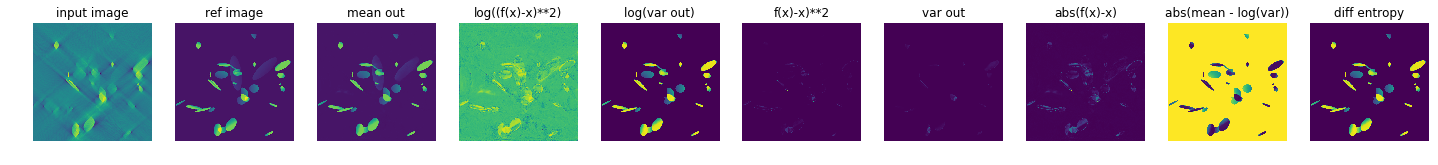

var
max:  2.6299392e-06
min:  0.0
sum:  0.00061967777
mean
max:  0.80168176
min:  0.020988053
sum:  24268.562
log var
max:  -12.84855
min:  -inf
sum:  -inf
Image 1 from train data


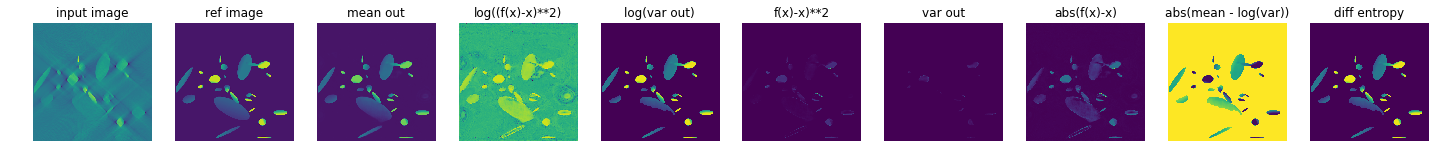

var
max:  7.647303e-06
min:  0.0
sum:  0.0024660642
mean
max:  0.8079079
min:  0.019830436
sum:  27288.227
log var
max:  -11.7811575
min:  -inf
sum:  -inf
Image 2 from train data


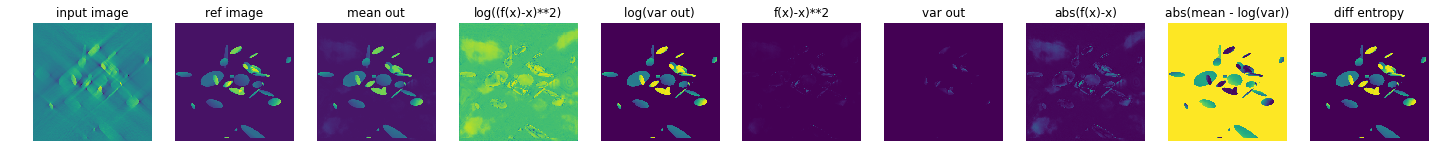

var
max:  3.6032005e-05
min:  0.0
sum:  0.004397175
mean
max:  0.81668234
min:  0.025327902
sum:  37443.3
log var
max:  -10.231103
min:  -inf
sum:  -inf
Image 3 from train data


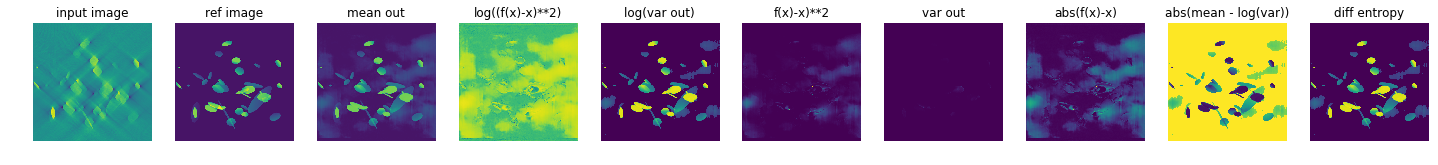

var
max:  2.9355171e-05
min:  0.0
sum:  0.006682839
mean
max:  0.81554025
min:  0.015128838
sum:  30612.035
log var
max:  -10.436042
min:  -inf
sum:  -inf
Image 4 from train data


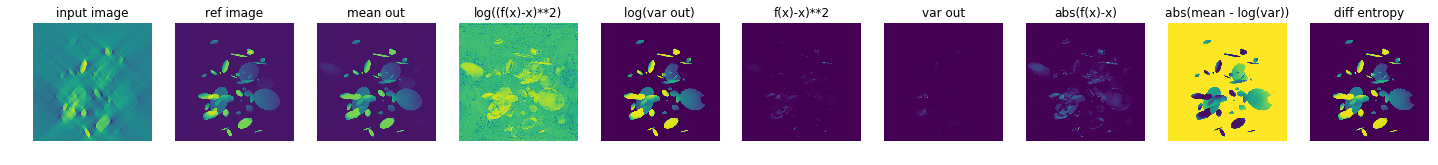

var
max:  1.1085146e-05
min:  0.0
sum:  0.0050410815
mean
max:  0.8100382
min:  0.017576423
sum:  28782.434
log var
max:  -11.4099045
min:  -inf
sum:  -inf
Image 5 from train data


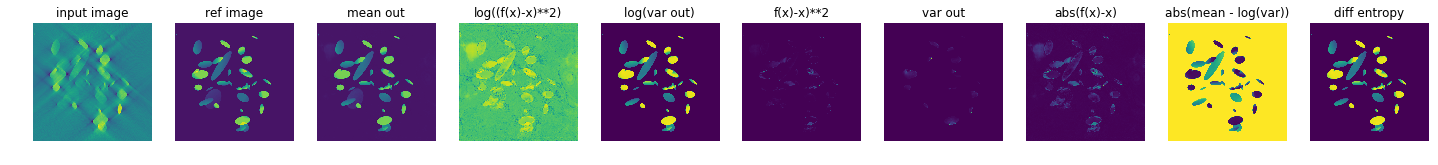

In [6]:
make_plot_prob(train_matrices_path, 'train', 6)

var
max:  8.103139e-06
min:  0.0
sum:  0.002354312
mean
max:  0.8082413
min:  0.018473938
sum:  26089.217
log var
max:  -11.723259
min:  -inf
sum:  -inf
Image 0 from test data


/home/oala/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/home/oala/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/home/oala/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


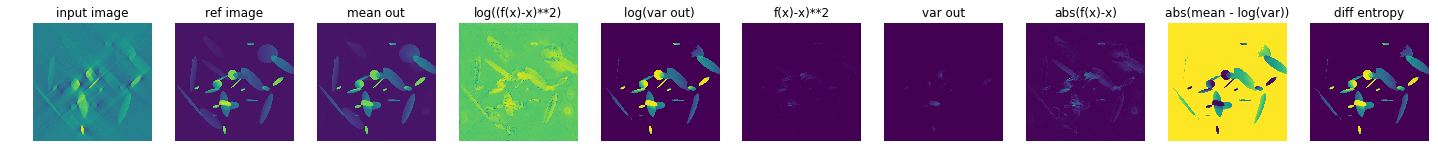

var
max:  1.9438996e-05
min:  0.0
sum:  0.0020940702
mean
max:  0.81322676
min:  0.02548908
sum:  38653.098
log var
max:  -10.848229
min:  -inf
sum:  -inf
Image 1 from test data


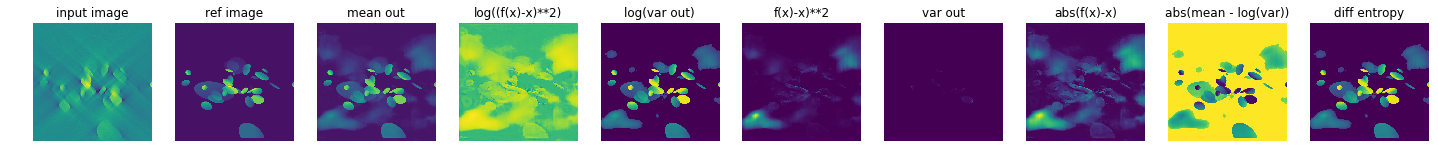

var
max:  1.7275185e-06
min:  0.0
sum:  0.00047498418
mean
max:  0.7991889
min:  0.023796046
sum:  29098.273
log var
max:  -13.268825
min:  -inf
sum:  -inf
Image 2 from test data


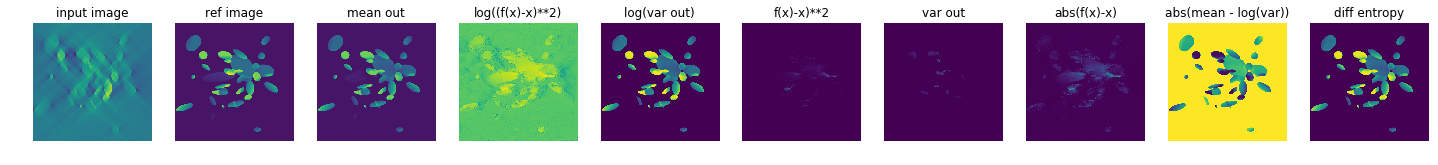

var
max:  1.0098403e-06
min:  0.0
sum:  0.0004162156
mean
max:  0.79597044
min:  0.02147047
sum:  28126.771
log var
max:  -13.805718
min:  -inf
sum:  -inf
Image 3 from test data


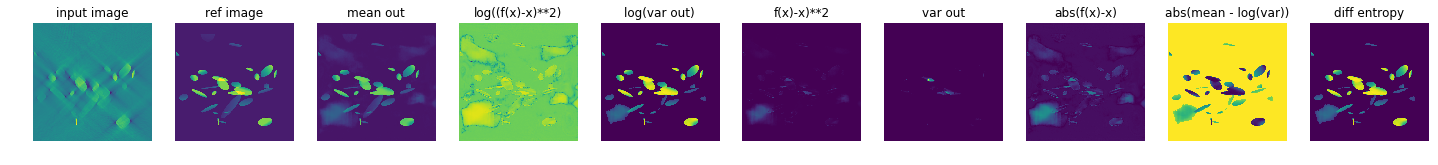

var
max:  3.8206094e-06
min:  0.0
sum:  0.0013626845
mean
max:  0.8038772
min:  0.022915509
sum:  27549.223
log var
max:  -12.4751005
min:  -inf
sum:  -inf
Image 4 from test data


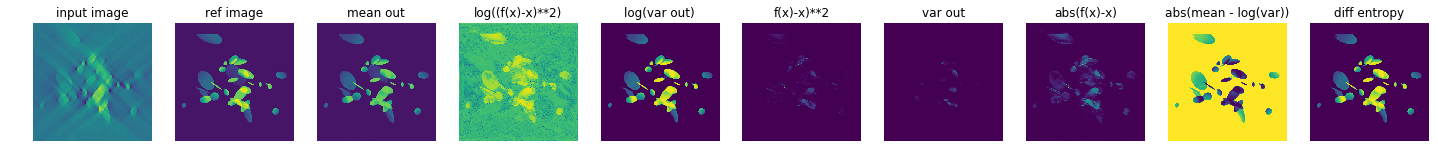

var
max:  9.228553e-06
min:  0.0
sum:  0.0011975339
mean
max:  0.80898863
min:  0.027500818
sum:  53730.47
log var
max:  -11.593208
min:  -inf
sum:  -inf
Image 5 from test data


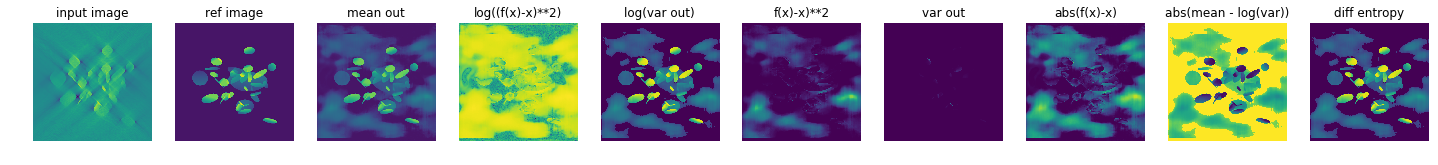

In [7]:
make_plot_prob(test_matrices_path, 'test', 6)

In [22]:
train_matrices_path_det = "/home/oala/Documents/experiments-hhi/uncertainty-quant/preliminary-experiments/denoising/drop/run-2_sigout/matrices-train/epoch9.pickle"
test_matrices_path_det = "/home/oala/Documents/experiments-hhi/uncertainty-quant/preliminary-experiments/denoising/drop/run-2_sigout/matrices-test/epoch9.pickle"

Image 0 from train data


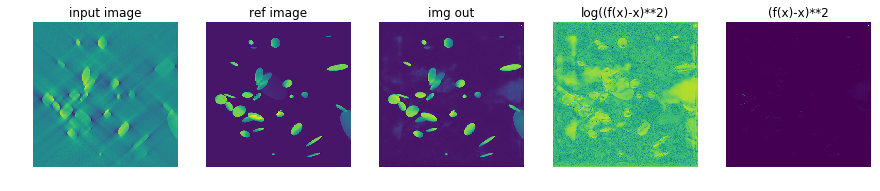

Image 1 from train data


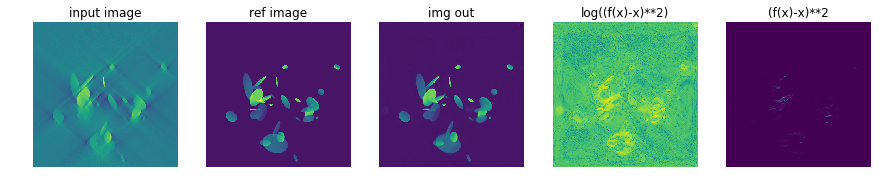

Image 2 from train data


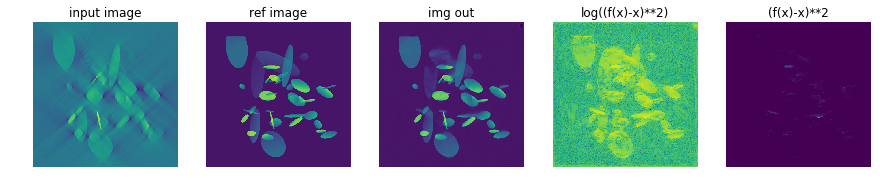

Image 3 from train data


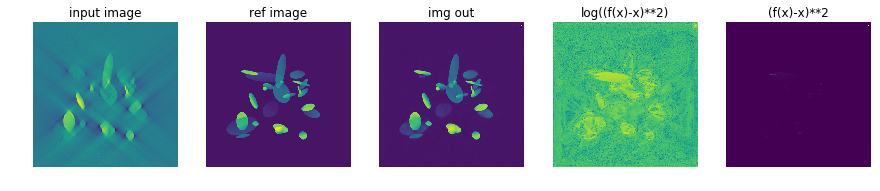

Image 4 from train data


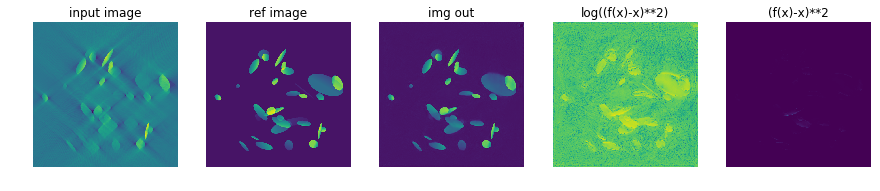

Image 5 from train data


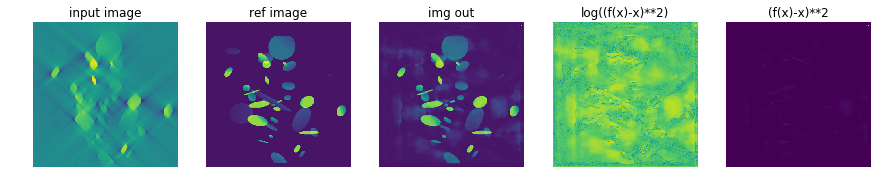

In [23]:
make_plot_det(train_matrices_path_det, 'train', 6)

Image 0 from test data


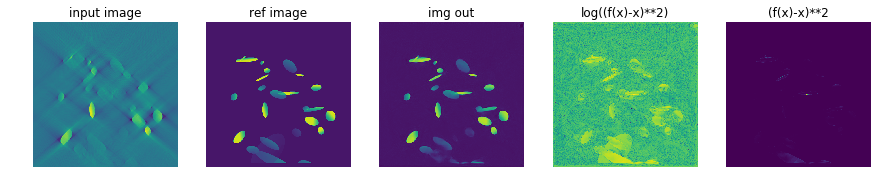

Image 1 from test data


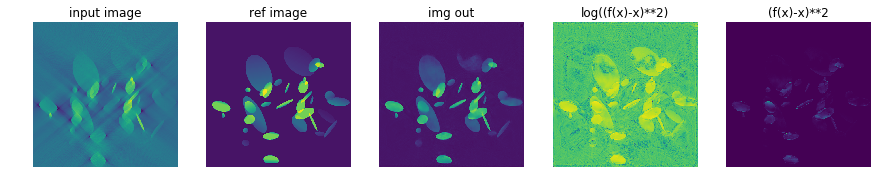

Image 2 from test data


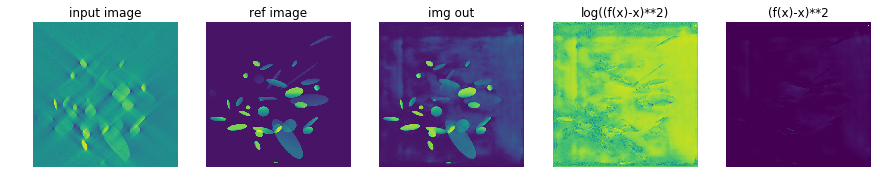

Image 3 from test data


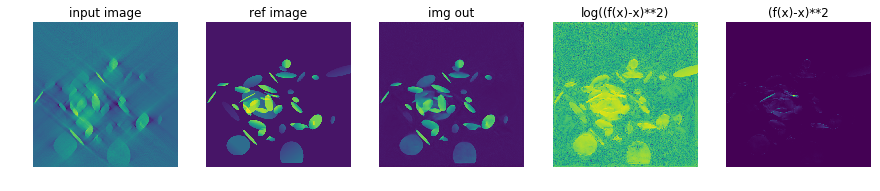

Image 4 from test data


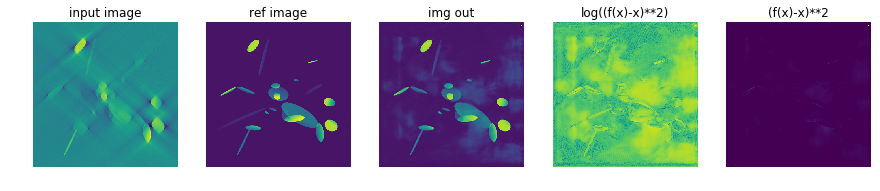

Image 5 from test data


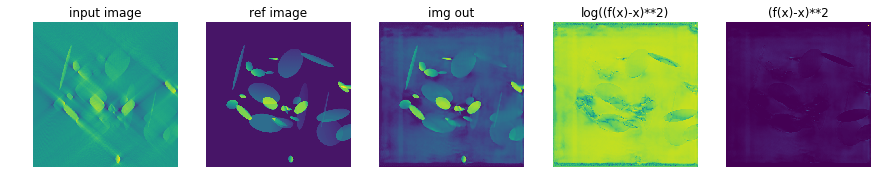

In [24]:
make_plot_det(test_matrices_path_det, 'test', 6)